In [8]:

# Investigate the presence of colors
colors_list = [
    'red',
    'yellow',
    'black',
    'gray',
    'green'
]
for color in colors_list:
    srs = frvrs_logs_df.applymap(lambda x: color in str(x).lower(), na_action='ignore').sum()
    columns_list = srs[srs != 0].index.tolist()
    if columns_list:
        print(color, columns_list)

red ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
yellow ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
black ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
gray ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']
green ['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']


In [ ]:
 if any(map(lambda x: (x in fn), ['class', 'featur']))

In [6]:

loop1 = frvrs_logs_df.groupby(['session_uuid', 'time_group', 'patient_id']).size().shape[0]
input_features = [
    'patient_record_salt', 'patient_record_sort', 'patient_record_pulse', 'patient_record_breath', 'patient_record_hearing', 'patient_record_mood',
    'patient_record_pose', 'injury_record_id', 'injury_record_required_procedure', 'injury_record_severity', 'injury_record_body_region',
    'injury_record_injury_treated', 'injury_record_injury_treated_with_wrong_treatment', 'pulse_taken_pulse_name', 'patient_engaged_salt',
    'patient_engaged_sort', 'patient_engaged_pulse', 'patient_engaged_breath', 'patient_engaged_hearing', 'patient_engaged_mood', 'patient_engaged_pose',
    'injury_treated_id', 'injury_treated_required_procedure', 'injury_treated_severity', 'injury_treated_body_region', 'injury_treated_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment', 'tool_applied_type', 'tool_applied_attachment_point', 'tool_applied_tool_location',
    'tool_applied_data', 'tool_applied_sender'
    ]
loop2 = len(input_features)
loop3 = frvrs_logs_df.action_type.unique().shape[0]
loop_total = loop1 * loop2 * loop3
print(f"I'm looping through each patient, run, and session (x{loop1:,}) and the input features columns (x{loop2}) prepended with each of the action types (x{loop3}) for a total of {loop_total:,} loops.")

I'm looping through each patient, run, and session (x9,874) and the input features columns (x32) prepended with each of the action types (x26) for a total of 8,215,168 loops.


,notice_to_control_time,responder_count
0,11219.0,98.0
1,258123.4,169.0
2,505027.8,140.0
3,751932.2,120.0
4,998836.6,56.0
5,1245741.0,22.0
6,1492645.4,7.0
7,1739549.8,0.0
8,1986454.2,5.0
9,2233358.6,1.0


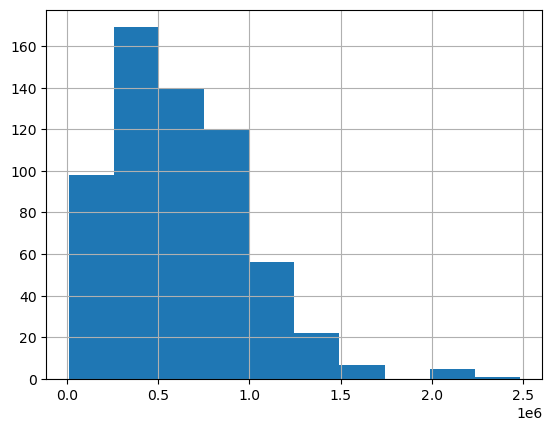

In [31]:

df = notice_to_control_time_df.groupby(groupby_columns).sum()
hist_obj = df.notice_to_control_time.hist()
[f'hist_obj.{fn}' for fn in dir(hist_obj) if any(map(lambda x: x in fn, ['height', 'bin', 'patch']))]

# Extract heights and x-coordinates of the bars
rows_list = [{'notice_to_control_time': rect.get_x(), 'responder_count': rect.get_height()} for rect in hist_obj.patches]
pd.DataFrame(rows_list)

In [30]:

[f'hist_obj.{fn}' for fn in dir(hist_obj) if fn.startswith('get_')]

['hist_obj.get_adjustable', 'hist_obj.get_agg_filter', 'hist_obj.get_alpha', 'hist_obj.get_anchor', 'hist_obj.get_animated', 'hist_obj.get_aspect', 'hist_obj.get_autoscale_on', 'hist_obj.get_autoscalex_on', 'hist_obj.get_autoscaley_on', 'hist_obj.get_axes_locator', 'hist_obj.get_axisbelow', 'hist_obj.get_box_aspect', 'hist_obj.get_children', 'hist_obj.get_clip_box', 'hist_obj.get_clip_on', 'hist_obj.get_clip_path', 'hist_obj.get_cursor_data', 'hist_obj.get_data_ratio', 'hist_obj.get_default_bbox_extra_artists', 'hist_obj.get_facecolor', 'hist_obj.get_fc', 'hist_obj.get_figure', 'hist_obj.get_frame_on', 'hist_obj.get_gid', 'hist_obj.get_gridspec', 'hist_obj.get_images', 'hist_obj.get_in_layout', 'hist_obj.get_label', 'hist_obj.get_legend', 'hist_obj.get_legend_handles_labels', 'hist_obj.get_lines', 'hist_obj.get_mouseover', 'hist_obj.get_navigate', 'hist_obj.get_navigate_mode', 'hist_obj.get_path_effects', 'hist_obj.get_picker', 'hist_obj.get_position', 'hist_obj.get_rasterization_zorde

In [29]:

  #   +------------------+
  #   |                  |
  # height               |
  #   |                  |
  #  (xy)---- width -----+
hist_obj.patch?

Type:           Rectangle
String form:    Rectangle(xy=(0, 0), width=1, height=1, angle=0)
File:           c:\users\davebabbitt\documents\github\notebooks\nb_env\lib\site-packages\matplotlib\patches.py
Docstring:     
A rectangle defined via an anchor point *xy* and its *width* and *height*.

The rectangle extends from ``xy[0]`` to ``xy[0] + width`` in x-direction
and from ``xy[1]`` to ``xy[1] + height`` in y-direction. ::

  :                +------------------+
  :                |                  |
  :              height               |
  :                |                  |
  :               (xy)---- width -----+

One may picture *xy* as the bottom left corner, but which corner *xy* is
actually depends on the direction of the axis and the sign of *width*
and *height*; e.g. *xy* would be the bottom right corner if the x-axis
was inverted or if *width* was negative.
Init docstring:
Parameters
----------
xy : (float, float)
    The anchor point.
width : float
    Rectangle width.
h

In [28]:

for patch in hist_obj.patches:
    display(dir(patch))
    break

['_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alias_map', '_alpha', '_animated', '_antialiased', '_aspect_ratio_correction', '_axes', '_callbacks', '_capstyle', '_clipon', '_clippath', '_cm_set', '_convert_units', '_convert_xy_units', '_dash_pattern', '_default_contains', '_draw_paths_with_artist_properties', '_edge_default', '_edgecolor', '_facecolor', '_fill', '_fully_clipped_to_axes', '_gid', '_hatch', '_hatch_color', '_height', '_in_layout', '_internal_update', '_joinstyle', '_label', '_linestyle', '_linewidth', '_mouseover', '_original_edgecolor', '_original_facecolor', '_path_effects', '_picker', '_process_radius', '_rast

In [24]:

from collections import Counter

# Count the lengths of sequences in consecutive_time_groups_dict
sequence_lengths = [len(actions_list) for actions_list in time_groups_dict.values()]

# Find the most common sequence length and its count
most_common_length, count = Counter(sequence_lengths).most_common(1)[0]

print(f'The most popular sequence length among the values of the time_groups_dict is {most_common_length}, occurring {count} times.')

The most popular sequence length among the values of the time_groups_dict is 1, occurring 58 times.


In [25]:

import pandas as pd
from collections import Counter

# Count the lengths of sequences in consecutive_time_groups_dict
sequence_lengths = [len(actions_list) for actions_list in consecutive_time_groups_dict.values()]

# Convert sequence_lengths list into a pandas Series
sequence_lengths_series = pd.Series(sequence_lengths)

# Get the value counts of unique sequence lengths
value_counts = sequence_lengths_series.value_counts()

print('Value counts of unique sequence lengths of the consecutive_time_groups_dict:')
print(value_counts)

Value counts of unique sequence lengths:
3     187
5     125
1      82
4      74
7      64
6      51
2      45
9      29
10     21
8      15
11     10
12      8
13      7
14      4
16      2
15      1
Name: count, dtype: int64


In [10]:

import random

values_list = random.sample(notice_to_control_time_df.notice_to_control_time.tolist(), 10)
print(f'''
notice_to_control_time_df = pd.DataFrame({{'notice_to_control_time': {values_list}}})''')


notice_to_control_time_df = pd.DataFrame({'notice_to_control_time': [565204, 66933, 180636, 170767, 266339, 255253, 244320, 82204, 93897, 363529]})


In [ ]:

.sort_values(list(columns_dict.values()), ascending=[False]*len(columns_dict.values()))

In [ ]:

            # print(previous_time, elapsed_time, session_uuid, time_group, patient_id, previous_time > elapsed_time)
            if (previous_time > elapsed_time):
                display(df1[mask_series].sort_values('elapsed_time').head(4).dropna(axis='columns', how='all').T)
                display(df2.sample(min(4, df2.shape[0])).dropna(axis='columns', how='all').T)
                raise

In [ ]:

    print(f"""
    groupby_columns = {df.columns.tolist()}
    gb = df.groupby(groupby_columns)
    rows_list = []
    for ({', '.join(df.columns)}), df1 in gb:""")

In [ ]:

    
    # Investigate the presence of trunk, neck, junctional or extremity info
    for search_str in ['trunk', 'neck', 'junctional', 'extremity']:
        srs = df2.applymap(lambda x: search_str in str(x).lower(), na_action='ignore').sum()
        columns_list = srs[srs != 0].index.tolist()
        if columns_list:
            print(search_str, columns_list)

In [ ]:

required_columns_list = [cn for cn in frvrs_logs_df.columns if cn.endswith('_required_procedure')]
mask_series = False
for cn in required_columns_list: mask_series |= (frvrs_logs_df[cn].isin(['tourniquet', 'woundpack']))

In [ ]:

fn = lambda x: ('gaze' in str(x).lower())
srs = frvrs_logs_df.applymap(fn, na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
print(columns_list)
for cn in columns_list:
    print(cn)
    mask_series = frvrs_logs_df[cn].map(fn)
    df = frvrs_logs_df[mask_series]
    
    # Display a sample of the data frame, dropping columns with all NaN values and transposing it
    display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

In [ ]:


# tick_locations = ax.get_xticks()
# print(tick_locations)

# tick_labels = ax.get_xticklabels()
# print(tick_labels)